In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from joblib import dump, load

from nltk.tokenize import RegexpTokenizer
from sklearn.decomposition import TruncatedSVD
import xgboost as xgb

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

train['train_test'] = 'train'
test['train_test'] = 'test'

data = pd.concat([train, test])

/usr/lib/python3/dist-packages/ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


In [3]:
data.shape

(258210, 16)

In [4]:
test.shape

(83210, 16)

In [5]:
data.head()

,country,description,designation,id,index,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,train_test,variety,winery
0,Portugal,This is a fine rich balanced wine. It has ripe...,Vila Santa Reserva,32027,NaN,88.870874,20.0,Alentejano,NaN,NaN,NaN,NaN,NaN,train,PORTUGUESE RED,J. Portugal Ramos
1,France,"A solid, chunky wine, with a structure that is...",NaN,71079,NaN,88.041695,28.0,Bordeaux,Lalande de Pomerol,NaN,NaN,NaN,NaN,train,BORDEAUX-STYLE RED BLEND,Château Tour Grand Colombier
2,France,"This is powerful and concentrated, with the hi...",NaN,32440,NaN,94.085021,130.0,Bordeaux,Saint-Émilion,NaN,NaN,NaN,NaN,train,BORDEAUX-STYLE RED BLEND,Château Figeac
3,US,"Rich, ripe and oaky, this Petite Sirah charms ...",Thompson Vineyard,124405,NaN,89.869797,34.0,California,Santa Barbara County,Central Coast,NaN,NaN,Jaffurs 2010 Thompson Vineyard Petite Sirah (S...,train,PETITE SIRAH,Jaffurs
4,US,This wine is a unique in the state blend and f...,McKinley Springs Vineyard,33649,NaN,89.017651,24.0,Washington,Horse Heaven Hills,Columbia Valley,Sean P. Sullivan,@wawinereport,Syncline 2016 McKinley Springs Vineyard Rosé (...,train,ROSé,Syncline


In [6]:
data['province'].mode()

0    California
dtype: object

In [7]:
data.variety.fillna(value='PINOT NOIR', inplace=True)

In [8]:
data.province.fillna(value='California', inplace=True)

In [9]:
#data = data[pd.notnull(data['variety'])]
#data = data[pd.notnull(data['province'])]

In [10]:
data.taster_name.fillna(value='Roger Voss', inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 258210 entries, 0 to 83209
Data columns (total 16 columns):
country                  258146 non-null object
description              258210 non-null object
designation              181120 non-null object
id                       258210 non-null int64
index                    83210 non-null float64
points                   258210 non-null float64
price                    175000 non-null float64
province                 258210 non-null object
region_1                 215793 non-null object
region_2                 110996 non-null object
taster_name              258210 non-null object
taster_twitter_handle    91559 non-null object
title                    120975 non-null object
train_test               258210 non-null object
variety                  258210 non-null object
winery                   258210 non-null object
dtypes: float64(3), int64(1), object(12)
memory usage: 33.5+ MB


In [11]:
data.title.fillna(value='Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma County)', inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 258210 entries, 0 to 83209
Data columns (total 16 columns):
country                  258146 non-null object
description              258210 non-null object
designation              181120 non-null object
id                       258210 non-null int64
index                    83210 non-null float64
points                   258210 non-null float64
price                    175000 non-null float64
province                 258210 non-null object
region_1                 215793 non-null object
region_2                 110996 non-null object
taster_name              258210 non-null object
taster_twitter_handle    91559 non-null object
title                    258210 non-null object
train_test               258210 non-null object
variety                  258210 non-null object
winery                   258210 non-null object
dtypes: float64(3), int64(1), object(12)
memory usage: 33.5+ MB


In [12]:
data['province'] = pd.Categorical(data['province'])
proDummies = pd.get_dummies(data['province'], prefix = 'prov')

data['country'] = pd.Categorical(data['country'])
countDummies = pd.get_dummies(data['country'], prefix = 'country')

data['variety'] = pd.Categorical(data['variety'])
varDummies = pd.get_dummies(data['variety'], prefix = 'variety')

data['taster_name'] = pd.Categorical(data['taster_name'])
tastDummies = pd.get_dummies(data['taster_name'], prefix = 'taster')

#data['title'] = pd.Categorical(data['title'])
#titleDummies = pd.get_dummies(data['title'], prefix = 'title')

In [13]:
def getQuality(points):
    if(points <= 85):
        return 'bad'
    elif(points<=90 ):
        return 'ok'
    elif(points<=95):
        return 'good'
    elif(points<=102):
        return 'great'
    else:
        return 'If this gets hit, we did something wrong!'

In [14]:
data['quality'] = data['points'].apply(getQuality)
cleanup_nums = {"quality":     {"ok": 2, "good": 3, "bad": 1, "great": 4},
                "priceRange": {"1-30": 1, "31-50": 2, "51-100": 3, "Above 100": 4}}

data.replace(cleanup_nums, inplace=True)

In [15]:
data.head()

,country,description,designation,id,index,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,train_test,variety,winery,quality
0,Portugal,This is a fine rich balanced wine. It has ripe...,Vila Santa Reserva,32027,NaN,88.870874,20.0,Alentejano,NaN,NaN,Roger Voss,NaN,Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma...,train,PORTUGUESE RED,J. Portugal Ramos,2
1,France,"A solid, chunky wine, with a structure that is...",NaN,71079,NaN,88.041695,28.0,Bordeaux,Lalande de Pomerol,NaN,Roger Voss,NaN,Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma...,train,BORDEAUX-STYLE RED BLEND,Château Tour Grand Colombier,2
2,France,"This is powerful and concentrated, with the hi...",NaN,32440,NaN,94.085021,130.0,Bordeaux,Saint-Émilion,NaN,Roger Voss,NaN,Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma...,train,BORDEAUX-STYLE RED BLEND,Château Figeac,3
3,US,"Rich, ripe and oaky, this Petite Sirah charms ...",Thompson Vineyard,124405,NaN,89.869797,34.0,California,Santa Barbara County,Central Coast,Roger Voss,NaN,Jaffurs 2010 Thompson Vineyard Petite Sirah (S...,train,PETITE SIRAH,Jaffurs,2
4,US,This wine is a unique in the state blend and f...,McKinley Springs Vineyard,33649,NaN,89.017651,24.0,Washington,Horse Heaven Hills,Columbia Valley,Sean P. Sullivan,@wawinereport,Syncline 2016 McKinley Springs Vineyard Rosé (...,train,ROSé,Syncline,2


In [16]:
def make_lower_case(text):
    return text.lower()

def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text

In [17]:
data["description"] = data["description"].str.replace('\d+', '')
data["description"] = data.description.apply(func=remove_punctuation)
data["description"] = data.description.apply(func=make_lower_case)

In [18]:
data["variety"] = data["variety"].str.replace('\d+', '')
data["variety"] = data.variety.apply(func=remove_punctuation)
data["variety"] = data.variety.apply(func=make_lower_case)

In [19]:
data["title"] = data["title"].str.replace('\d+', '')
data["title"] = data.title.apply(func=remove_punctuation)
data["title"] = data.title.apply(func=make_lower_case)

In [20]:
tf = TfidfVectorizer(analyzer='word', 
                     min_df=10,
                     ngram_range=(1, 2),
                     stop_words='english')
svd = TruncatedSVD(n_components=10)

In [21]:
#Fit tfidf and svd, and transform training data
tfidf_matrix = tf.fit_transform(data.description)
desc_features = pd.DataFrame(svd.fit_transform(tfidf_matrix))
collist = map(str, range(0, 10))
collist = ["description_" + s for s in collist]
desc_features.columns = collist
desc_features.head()

,description_0,description_1,description_2,description_3,description_4,description_5,description_6,description_7,description_8,description_9
0,0.115367,0.004756,0.115111,0.050601,0.008731,-0.030167,-0.027259,-0.028771,-0.030526,0.007450
1,0.119707,0.024866,0.072196,0.021710,-0.012001,-0.063497,0.001888,-0.021483,-0.028743,-0.009018
2,0.129262,0.101797,0.087940,0.002989,0.132426,-0.031738,-0.016531,0.013589,-0.062122,-0.007321
3,0.103500,0.062283,0.012032,-0.063759,-0.021644,-0.064178,-0.016038,0.017682,-0.048790,-0.058491
4,0.096223,-0.056729,-0.015282,-0.012613,0.022719,0.027589,0.005605,-0.020179,0.023416,-0.048911


In [22]:
tfidf_matrix = tf.fit_transform(data.variety)
var_features = pd.DataFrame(svd.fit_transform(tfidf_matrix))
collist = map(str, range(0, 10))
collist = ["variety_" + s for s in collist]
var_features.columns = collist
var_features.head()

,variety_0,variety_1,variety_2,variety_3,variety_4,variety_5,variety_6,variety_7,variety_8,variety_9
0,3.312200e-06,1.212704e-05,4.913818e-02,2.476380e-01,-6.607944e-05,0.000444,-0.000168,-0.000180,0.001270,-0.182056
1,1.047086e-05,4.099274e-05,1.488022e-01,7.480537e-01,-7.385202e-05,0.000775,0.000139,-0.000032,-0.000203,0.613694
2,1.047086e-05,4.099280e-05,1.488022e-01,7.480537e-01,-7.385202e-05,0.000775,0.000139,-0.000032,-0.000203,0.613694
3,-2.413910e-07,-2.599101e-06,7.434952e-07,-3.607524e-07,-3.945465e-05,-0.000085,0.000479,-0.000197,0.000467,-0.000097
4,7.649097e-09,-1.388571e-07,8.346308e-07,4.230936e-06,-1.384983e-07,0.000004,-0.000029,-0.000034,0.000507,-0.000306


In [23]:
prov_features = pd.DataFrame(svd.fit_transform(proDummies.values))
collist = map(str, range(0, 10))
collist = ["province_" + s for s in collist]
prov_features.columns = collist
prov_features.head()

,province_0,province_1,province_2,province_3,province_4,province_5,province_6,province_7,province_8,province_9
0,5.595310e-10,1.952098e-06,-8.012090e-06,-2.046554e-05,-1.113311e-04,-3.718648e-05,-4.667444e-04,2.675460e-04,-1.706950e-04,-5.858210e-06
1,3.644994e-13,9.238356e-09,-9.728699e-08,-6.466519e-07,6.303642e-07,-2.676486e-07,9.999970e-01,-4.315922e-05,2.112306e-05,-1.555614e-05
2,3.655878e-13,9.239865e-09,-9.728855e-08,-6.466701e-07,6.303637e-07,-2.676481e-07,9.999970e-01,-4.315922e-05,2.112306e-05,-1.555613e-05
3,1.000000e+00,1.395310e-15,3.355398e-15,-8.512316e-15,-3.798682e-14,-3.990688e-14,7.710518e-15,1.080814e-13,-1.401002e-13,2.588710e-13
4,-6.759702e-14,1.000000e+00,1.228598e-10,-9.899365e-10,-1.100507e-09,-2.065796e-09,-9.296505e-10,7.246603e-09,-9.272310e-09,1.723171e-08


In [24]:
#tfidf_matrix = tf.fit_transform(data.region_1)
#reg1_features = pd.DataFrame(svd.fit_transform(tfidf_matrix))
#collist = map(str, range(0, 10))
#collist = ["country_" + s for s in collist]
#reg1_features.columns = collist
#reg1_features.head()

In [25]:
country_features = pd.DataFrame(svd.fit_transform(countDummies.values))
collist = map(str, range(0, 10))
collist = ["country_" + s for s in collist]
country_features.columns = collist
country_features.head()

,country_0,country_1,country_2,country_3,country_4,country_5,country_6,country_7,country_8,country_9
0,-2.612078e-14,5.461437e-14,-5.023593e-14,3.255090e-14,1.466334e-13,-1.743498e-13,1.000000e+00,8.240748e-14,2.147084e-14,9.011567e-14
1,-4.209479e-13,-2.472297e-10,1.000000e+00,2.404592e-12,-1.563144e-13,2.601343e-13,2.161910e-13,-2.471882e-13,1.299045e-14,4.587202e-14
2,6.621501e-16,-3.555500e-14,1.000000e+00,9.753507e-13,-1.600444e-13,2.814877e-13,2.228293e-13,-2.761502e-13,-1.669779e-14,-5.700425e-14
3,1.000000e+00,3.032758e-15,2.282266e-15,-5.891159e-15,3.548969e-13,-3.504328e-13,-5.960591e-13,2.251390e-13,-1.059609e-16,6.042000e-16
4,1.000000e+00,-1.422093e-14,1.113318e-13,1.160328e-12,4.382431e-11,-4.992734e-11,-7.679914e-11,2.729018e-11,2.861126e-15,-2.288119e-15


In [26]:
dd = pd.concat([desc_features, var_features, prov_features, country_features], axis=1)
dd.shape

(258210, 40)

In [27]:
dd.head()

,description_0,description_1,description_2,description_3,description_4,description_5,description_6,description_7,description_8,description_9,...,country_0,country_1,country_2,country_3,country_4,country_5,country_6,country_7,country_8,country_9
0,0.115367,0.004756,0.115111,0.050601,0.008731,-0.030167,-0.027259,-0.028771,-0.030526,0.007450,...,-2.612078e-14,5.461437e-14,-5.023593e-14,3.255090e-14,1.466334e-13,-1.743498e-13,1.000000e+00,8.240748e-14,2.147084e-14,9.011567e-14
1,0.119707,0.024866,0.072196,0.021710,-0.012001,-0.063497,0.001888,-0.021483,-0.028743,-0.009018,...,-4.209479e-13,-2.472297e-10,1.000000e+00,2.404592e-12,-1.563144e-13,2.601343e-13,2.161910e-13,-2.471882e-13,1.299045e-14,4.587202e-14
2,0.129262,0.101797,0.087940,0.002989,0.132426,-0.031738,-0.016531,0.013589,-0.062122,-0.007321,...,6.621501e-16,-3.555500e-14,1.000000e+00,9.753507e-13,-1.600444e-13,2.814877e-13,2.228293e-13,-2.761502e-13,-1.669779e-14,-5.700425e-14
3,0.103500,0.062283,0.012032,-0.063759,-0.021644,-0.064178,-0.016038,0.017682,-0.048790,-0.058491,...,1.000000e+00,3.032758e-15,2.282266e-15,-5.891159e-15,3.548969e-13,-3.504328e-13,-5.960591e-13,2.251390e-13,-1.059609e-16,6.042000e-16
4,0.096223,-0.056729,-0.015282,-0.012613,0.022719,0.027589,0.005605,-0.020179,0.023416,-0.048911,...,1.000000e+00,-1.422093e-14,1.113318e-13,1.160328e-12,4.382431e-11,-4.992734e-11,-7.679914e-11,2.729018e-11,2.861126e-15,-2.288119e-15


In [28]:
dd.shape

(258210, 40)

In [29]:
#data.drop('index', axis=1, inplace=True)

In [30]:
dd['train_test'] = data.train_test.values

In [31]:
dd['id'] = data.id.values

In [32]:
dd['quality'] = data.quality.values

In [33]:
dd['points'] = data.points.values

In [34]:
dd['price'] = data.price.values

In [35]:
#['id', 'points', 'quality', 'price']
final_data = dd.copy()
final_data.shape

(258210, 45)

In [36]:
final_data['div_points'] = final_data['points'].values / 2
final_data['div_points_4'] = final_data['points'].values / 4
final_data['div_points_8'] = final_data['points'].values / 8

In [37]:
final_data['sum_desc'] = final_data[['description_0', 'description_1', 'description_2', 'description_3',
       'description_4', 'description_5', 'description_6', 'description_7',
       'description_8', 'description_9']].sum(axis=1)
final_data['sum_var'] = final_data[['variety_0', 'variety_1', 'variety_2',
       'variety_3', 'variety_4', 'variety_5', 'variety_6', 'variety_7',
       'variety_8', 'variety_9']].sum(axis=1)
final_data['sum_prov'] = final_data[['province_0', 'province_1', 'province_2',
       'province_3', 'province_4', 'province_5', 'province_6', 'province_7',
       'province_8', 'province_9']].sum(axis=1)
final_data['sum_country'] = final_data[['variety_0', 'variety_1', 'variety_2',
       'variety_3', 'variety_4', 'variety_5', 'variety_6', 'variety_7',
       'variety_8', 'variety_9']].sum(axis=1)

In [38]:
final_data['description_0_x4'] = final_data['description_0'].multiply(4)
final_data['description_0_x4'].head()

0    0.461469
1    0.478828
2    0.517048
3    0.413999
4    0.384893
Name: description_0_x4, dtype: float64

In [39]:
final_data['description_1_x4'] = final_data['description_1'].multiply(4)
final_data['description_1_x4'].head()

0    0.019025
1    0.099463
2    0.407188
3    0.249131
4   -0.226915
Name: description_1_x4, dtype: float64

In [40]:
#final_data['div_points'].head(10)
final_data.head()

,description_0,description_1,description_2,description_3,description_4,description_5,description_6,description_7,description_8,description_9,...,price,div_points,div_points_4,div_points_8,sum_desc,sum_var,sum_prov,sum_country,description_0_x4,description_1_x4
0,0.115367,0.004756,0.115111,0.050601,0.008731,-0.030167,-0.027259,-0.028771,-0.030526,0.007450,...,20.0,44.435437,22.217719,11.108859,0.185295,0.116036,-0.000551,0.116036,0.461469,0.019025
1,0.119707,0.024866,0.072196,0.021710,-0.012001,-0.063497,0.001888,-0.021483,-0.028743,-0.009018,...,28.0,44.020848,22.010424,11.005212,0.105622,1.511206,0.999959,1.511206,0.478828,0.099463
2,0.129262,0.101797,0.087940,0.002989,0.132426,-0.031738,-0.016531,0.013589,-0.062122,-0.007321,...,130.0,47.042511,23.521255,11.760628,0.350291,1.511206,0.999959,1.511206,0.517048,0.407188
3,0.103500,0.062283,0.012032,-0.063759,-0.021644,-0.064178,-0.016038,0.017682,-0.048790,-0.058491,...,34.0,44.934899,22.467449,11.233725,-0.077405,0.000525,1.000000,0.000525,0.413999,0.249131
4,0.096223,-0.056729,-0.015282,-0.012613,0.022719,0.027589,0.005605,-0.020179,0.023416,-0.048911,...,24.0,44.508825,22.254413,11.127206,0.021838,0.000146,1.000000,0.000146,0.384893,-0.226915


In [41]:
train_data = final_data[final_data['train_test'] == 'train']
test_data = final_data[final_data['train_test'] == 'test']

In [42]:
print(train_data.shape)
print(test_data.shape)

(175000, 54)
(83210, 54)


In [43]:
#cols = ['description_0', 'description_1', 'description_2', 'description_3', 'description_4', 'description_5', 'description_6', 'description_7', 'description_8', 'description_9', 'variety_0', 'variety_1', 'variety_2', 'variety_3', 'variety_4', 'variety_5', 'variety_6', 'variety_7', 'variety_8', 'variety_9', 'province_0', 'province_1', 'province_2', 'province_3', 'province_4', 'province_5', 'province_6', 'province_7', 'province_8', 'province_9', 'country_0', 'country_1', 'country_2', 'country_3', 'country_4', 'country_5', 'country_6', 'country_7', 'country_8', 'country_9', 'sum_desc', 'sum_var', 'sum_prov', 'sum_country', 'description_0_x4', 'description_1_x4']
#cols2 = ['points', 'quality']

In [44]:
#X = train_data[cols2]
#y = train_data["price"]

In [45]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [46]:
#print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

In [47]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures

In [48]:
pf = PolynomialFeatures(degree=2, interaction_only=False,  
                        include_bias=False)
res = pf.fit_transform(final_data[['points', 'quality']])
res

array([[8.88708744e+01, 2.00000000e+00, 7.89803232e+03, 1.77741749e+02,
        4.00000000e+00],
       [8.80416953e+01, 2.00000000e+00, 7.75134011e+03, 1.76083391e+02,
        4.00000000e+00],
       [9.40850213e+01, 3.00000000e+00, 8.85199123e+03, 2.82255064e+02,
        9.00000000e+00],
       ...,
       [8.90575848e+01, 2.00000000e+00, 7.93125341e+03, 1.78115170e+02,
        4.00000000e+00],
       [8.49079088e+01, 1.00000000e+00, 7.20935297e+03, 8.49079088e+01,
        1.00000000e+00],
       [9.20387015e+01, 3.00000000e+00, 8.47112258e+03, 2.76116105e+02,
        9.00000000e+00]])

In [49]:
pd.DataFrame(pf.powers_, columns=['points_degree',  
                                  'quality_degree'])

,points_degree,quality_degree
0,1,0
1,0,1
2,2,0
3,1,1
4,0,2


In [50]:
intr_features = pd.DataFrame(res, columns=['points', 'quality',  
                                           'points^2', 
                                           'points x quality',  
                                           'quality^2'])
intr_features.head(5)

,points,quality,points^2,points x quality,quality^2
0,88.870874,2.0,7898.032315,177.741749,4.0
1,88.041695,2.0,7751.340111,176.083391,4.0
2,94.085021,3.0,8851.991227,282.255064,9.0
3,89.869797,2.0,8076.580454,179.739594,4.0
4,89.017651,2.0,7924.142166,178.035302,4.0


In [51]:
intr_features['points_log'] = np.log((1 + intr_features['points']))

In [52]:
intr_features['points^2_log'] = np.log((1 + intr_features['points^2']))

In [53]:
intr_features['points x quality_log'] = np.log((1 + intr_features['points x quality']))

In [54]:
import scipy.stats as spstats

In [55]:
#intr_features['points_boxcox_lambda_0'] = spstats.boxcox((1 + intr_features['points']), lmbda=0)

In [56]:
#intr_features['points^2_boxcox_lambda_0'] = spstats.boxcox((1 + intr_features['points^2']), lmbda=0)

In [57]:
#intr_features['points x quality_boxcox_lambda_0'] = spstats.boxcox((1 + intr_features['points x quality']), lmbda=0)

In [58]:
l, opt_lambda = spstats.boxcox(intr_features['points'].values)
opt_lambda

0.050156705438200416

In [59]:
intr_features['points_boxcox_lambda_opt'] = spstats.boxcox((1 + intr_features['points']), 
                                          lmbda=opt_lambda)

In [60]:
intr_features['points^2_boxcox_lambda_opt'] = spstats.boxcox((1 + intr_features['points^2']), 
                                          lmbda=opt_lambda)

In [61]:
intr_features['points x quality_boxcox_lambda_opt'] = spstats.boxcox((1 + intr_features['points x quality']), 
                                          lmbda=opt_lambda)

In [62]:
intr_features.head()

,points,quality,points^2,points x quality,quality^2,points_log,points^2_log,points x quality_log,points_boxcox_lambda_opt,points^2_boxcox_lambda_opt,points x quality_boxcox_lambda_opt
0,88.870874,2.0,7898.032315,177.741749,4.0,4.498374,8.974496,5.185942,5.046263,11.334832,5.922886
1,88.041695,2.0,7751.340111,176.083391,4.0,4.489105,8.955750,5.176621,5.034650,11.305444,5.910799
2,94.085021,3.0,8851.991227,282.255064,9.0,4.554771,9.088511,5.646348,5.117035,11.514180,6.527014
3,89.869797,2.0,8076.580454,179.739594,4.0,4.509428,8.996848,5.197057,5.060118,11.369912,5.937307
4,89.017651,2.0,7924.142166,178.035302,4.0,4.500006,8.977796,5.187583,5.048308,11.340009,5.925015


In [63]:
print(intr_features.shape)

(258210, 11)


In [64]:
intr_features.drop(['quality', 'quality^2'], inplace=True, axis=1)

In [65]:
final_data_c = final_data.drop(['points', 'quality'], axis=1)

In [66]:
ff = pd.concat([final_data_c, intr_features], axis=1)

In [67]:
print(ff.shape)

(258210, 61)


In [68]:
train_ff = ff[ff['train_test'] == 'train']
test_ff = ff[ff['train_test'] == 'test']

In [69]:
col_old2 = ['description_0', 'description_1', 'description_2', 'description_3', 'description_4', 'description_5', 'description_6', 'description_7', 'description_8', 'description_9', 'variety_2', 'variety_4', 'variety_6', 'variety_7', 'variety_9', 'province_0', 'province_5', 'province_6', 'province_7', 'province_9', 'country_0', 'country_2', 'country_9', 'sum_desc', 'sum_prov', 'description_0_x4', 'description_1_x4']
col_old1 = ['description_0', 'description_1', 'description_2', 'description_3', 'description_4', 'description_5', 'description_6', 'description_7', 'description_8', 'description_9', 'variety_2', 'variety_4', 'variety_6', 'variety_7', 'variety_9', 'province_5', 'province_6', 'province_7', 'province_9', 'country_0', 'sum_desc', 'sum_prov', 'description_0_x4', 'description_1_x4']
col = ['description_0', 'description_1', 'description_2', 'description_3', 'description_4', 'description_5', 'description_6', 'description_7', 'description_8', 'description_9', 'variety_7', 'province_6', 'sum_desc', 'sum_prov', 'description_0_x4', 'description_1_x4']

X = train_ff[col + intr_features.columns.tolist()]
y = train_ff["price"]

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [71]:
#print(X_train.columns.tolist())

In [72]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
#Set xgboost parameters
param = {'max_depth': 3, 'eta': 1, 'subsample':0.5, 'alpha':1}
param['nthread'] = 4
param['eval_metric'] = 'mae'
param['objective'] = 'reg:linear'
param['silent'] = 1
evallist = [(dtrain, 'train')]
num_round = 10

#Train model
bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=10)

pred = pd.DataFrame(y_test.copy())
pred["prediction"] = bst.predict(dtest, ntree_limit=bst.best_ntree_limit)
rmse = np.round(np.sqrt(mean_squared_error(y_true=pred["price"], y_pred=pred["prediction"])), 2)
print ("Mean Squared Error: {} ".format(rmse))

[0]	train-mae:15.0911
Will train until train-mae hasn't improved in 10 rounds.


/home/aims/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[1]	train-mae:14.5408
[2]	train-mae:14.317
[3]	train-mae:14.2452
[4]	train-mae:14.2161
[5]	train-mae:14.1996
[6]	train-mae:14.1881
[7]	train-mae:14.1904
[8]	train-mae:14.077
[9]	train-mae:13.7102
Mean Squared Error: 34.23 


In [73]:
lm = Ridge()

lm.fit(X_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [74]:
print(lm.intercept_)

5738.890148844485


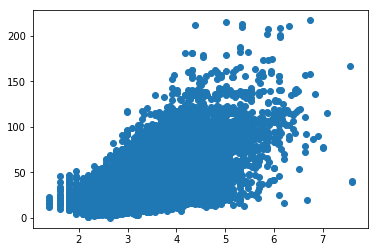

In [75]:
predictions = lm.predict(X_test)
plt.scatter(np.log(y_test),predictions)

In [76]:
print('RMSE:', np.sqrt(mean_squared_error(y_test, predictions)))

RMSE: 33.793430801914774


In [77]:
accuracy = lm.score(X_test, y_test)
print ("Accuracy is {}".format(accuracy))

Accuracy is 0.2735407084781367


In [78]:
rf = RandomForestRegressor()

In [79]:
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)

In [80]:
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [87]:
predicts = rf.predict(X_test)

In [88]:
print(y_test.shape, predicts.shape)

(52500,) (52500,)


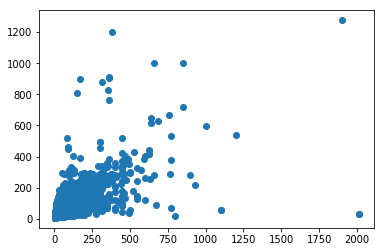

In [89]:
plt.scatter(y_test, predicts)

In [90]:
print('RMSE:', np.sqrt(mean_squared_error(y_test, predicts)))

RMSE: 27.259564253052282


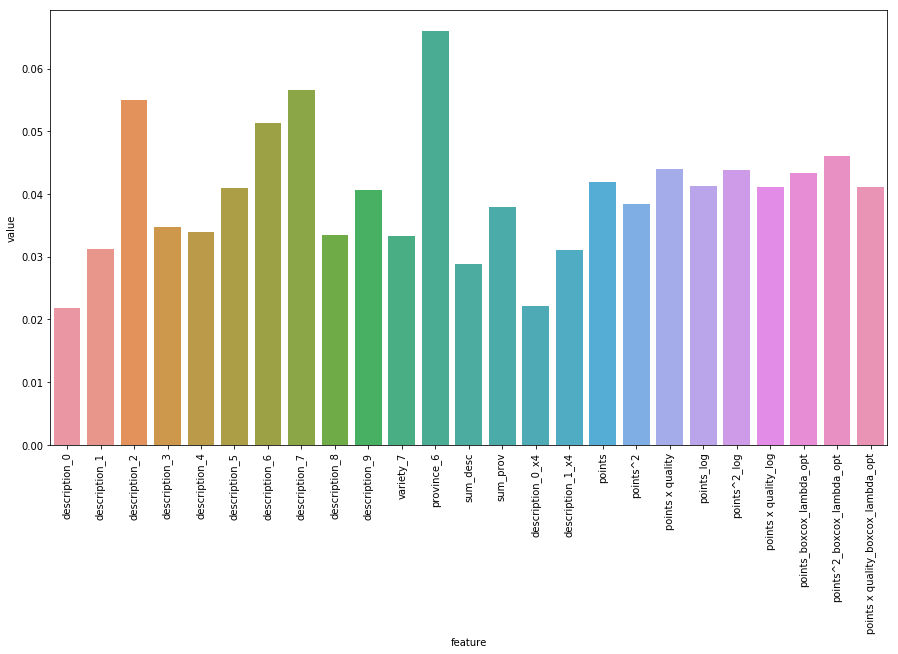

In [91]:
importance = pd.concat([pd.DataFrame(X_train.columns),pd.DataFrame(rf.feature_importances_)],axis=1)
importance.columns = ['feature','value']

plt.figure(figsize=(15,8))
sns.barplot(x="feature", y="value", data=importance).set_xticklabels(rotation=90,labels=X_train.columns)
print('')

In [96]:
#print(test_data.columns.tolist())

In [97]:
X_test_t = test_ff[col + intr_features.columns.tolist()]

In [98]:
print(X_train.shape, X_test_t.shape)

(122500, 25) (83210, 25)


In [100]:
test_ff['price'] = rf.predict(X_test_t)
test_ff['price'].head(10)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


175000    121.941
175001     55.380
175002     36.985
175003     29.092
175004     19.039
175005     22.085
175006     16.007
175007     24.866
175008     20.551
175009     48.620
Name: price, dtype: float64

In [ ]:
test_ff[['id', 'price']].to_csv('bma_price_predicted_rmse_lm29_86.csv', index=False)

In [ ]:
#pd.DataFrame(test_data_sss).to_csv('random_f.csv')

In [ ]:
import pickle

In [ ]:
pickle.dump(rf,open('rf_model_rmse23_19.sav','wb'))